In [202]:
import pandas as pd
import ipywidgets as widgets

import matplotlib as mpl
%matplotlib notebook
plt.ioff()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

from geonamescache import GeonamesCache
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


In [203]:
import os
os.chdir('/Users/phumphreys/Repositories/personal_calcs/Energy storage')
datafile = 'IEA_HeadlineEnergyData_2017.xlsx'
xl = pd.ExcelFile(datafile)
df1 = xl.parse('TimeSeries_1971-2016',skiprows=1)

In [204]:
import pycountry
import csv
import jellyfish
from incf.countryutils import transformations

countries_keyed_by_name = {(country.name.lower()):country.alpha_3 for country in list(pycountry.countries)}
countries_keyed_by_code = {country.alpha_3:(country.name.lower()) for country in list(pycountry.countries)}
country_iso3_list = countries_keyed_by_code.keys()

def correct_country_mispelling(s):
    with open("ISO3166ErrorDictionary.csv", "rb") as info:
        reader = csv.reader(info)
        for row in reader:
            if fuzzy_match(s.lower().decode('utf-8'),remove_non_ascii(row[0]).lower().decode('utf-8'),0.95):
                return row[2].lower()
    return s

# hat tip http://stackoverflow.com/a/1342373/2367526
def remove_non_ascii(s): return "".join(i for i in s if ord(i)<128)
 
def fuzzy_match(s1, s2, max_dist=.9):
    return jellyfish.jaro_distance(s1, s2) >= max_dist


def find_country_by_name(s): 

        s = remove_non_ascii(s).lower()
        s = correct_country_mispelling(s)

        matching = [x for x in countries_keyed_by_name if fuzzy_match(s.decode('utf-8'), x,0.95)]
        
        if len(matching) == 1:
            return countries_keyed_by_name[matching[0]]
        elif len(matching) > 1:
            raise LookupError('More than one country found!: ', matching)
        else:
            raise LookupError('No country found for: ', s)
        
def match_country_by_code_or_name(code,name = ''):
    try:
        country = pycountry.countries.lookup(code).alpha_3
    except:
        
        try:
            country = find_country_by_name(name)
        except:
            raise LookupError('Failed to match country')
    return country          

In [342]:
import copy

# Sort the IEA data in some not insane way
middle_eastern_countries = ['Bahrain', 'Iran', 'Iraq', 'Jordan', 'Kuwait', 'Lebanon', 'Oman', 'Qatar', 'Saudi Arabia', 'Syrian Arab Republic', 'United Arab Emirates', 'Yemen']
non_OECD_Eurasian_countries = ['Albania', 'Armenia', 'Azerbaijan', 'Belarus', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Macedonia', 'Georgia', 'Gibraltar', 'Kazakhstan', 'Kyrgyzstan', 'Lithuania', 'Malta', 'Moldova', 'Montenegro', 'Romania', 'Russian Federation', 'Serbia', 'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan']
non_OECD_asia = ['Bangladesh', 'Brunei Darussalam', 'Cambodia', 'Democratic People\xe2\x80\x99s Republic of Korea', 'India', 'Indonesia', 'Malaysia', 'Mongolia', 'Myanmar', 'Nepal', 'Pakistan', 'Philippines', 'Singapore', 'Sri Lanka', 'Taiwan, province of china', 'Thailand', 'Vietnam', 'Afghanistan', 'Bhutan', 'Cambodia', 'Cook Islands', 'Fiji', 'French Polynesia', 'Kiribati', "Lao People's Democratic Republic", 'Macao', 'Maldives', 'Mongolia', 'New Caledonia', 'Palau', 'Papua New Guinea', 'Samoa', 'Solomon Islands', 'Tonga', 'Vanuatu']

middle_eastern_country_codes = [find_country_by_name(country) for country in middle_eastern_countries]
non_OECD_Eurasian_country_codes = [find_country_by_name(country) for country in non_OECD_Eurasian_countries]
non_OECD_asia_country_codes = [find_country_by_name(country) for country in non_OECD_asia]

iea_specified_country_codes = {}
for country in df1.Country.unique().tolist():
    try:
        code = find_country_by_name(country)
        iea_specified_country_codes[code] = country
    except:
        pass
iea_specified_country_codes[u'CHN'] = "People's Republic of China"
iea_specified_country_codes[u'KOR'] = "Korea"
iea_specified_country_codes[u'SVK'] = "Slovak Republic"
iea_specified_country_codes[u'CZE'] = "Czech Republic"

iea_country_codes_to_named_region = copy.deepcopy(iea_specified_country_codes)
iea_country_codes_to_named_region[u'HKG'] = "People's Republic of China"

iea_country_codes_to_named_region.update({code:'Middle East' for code in middle_eastern_country_codes})
iea_country_codes_to_named_region.update({code:'Non-OECD Europe and Eurasia' for code in non_OECD_Eurasian_country_codes})
iea_country_codes_to_named_region.update({code:'Non-OECD Asia' for code in non_OECD_asia_country_codes})

african_country_codes = []
non_oecd_americas_country_codes = []
for iso3 in country_iso3_list:
    if iso3 not in iea_country_codes_to_named_region:
        try:
            cont_code = transformations.cca_to_ctca2(iso3)
            if cont_code == u'AF':
                iea_country_codes_to_named_region[iso3]='Africa'
                african_country_codes.append(iso3)
            elif cont_code == u'NA' or cont_code == u'SA':
                iea_country_codes_to_named_region[iso3]='Non-OECD Americas'
                non_oecd_americas_country_codes.append(iso3)
        except:
            pass


In [343]:
import wbpy
api = wbpy.IndicatorAPI()


def get_populations_from_wb(country_codes,year):
    total_population = "SP.POP.TOTL"
    dataset = api.get_dataset(total_population, country_codes, date=str(year))
    return {pycountry.countries.get(alpha_2=key).alpha_3:b.values()[0] for key, b in dataset.as_dict().iteritems()}

countries_in_wb = [u'AGO', u'DZA', u'EGY', u'BGD', u'NER', u'LIE', u'NAM', u'BGR', u'BOL', u'GHA', u'PAK', u'CPV', u'JOR', u'LBR', u'LBY', u'MYS', u'DOM', u'PRI', u'PRK', u'PSE', u'TZA', u'BWA', u'KHM', u'NIC', u'TTO', u'ETH', u'PRY', u'HKG', u'SAU', u'LBN', u'SVN', u'BFA', u'CHE', u'MRT', u'HRV', u'CHL', u'CHN', u'KNA', u'SLE', u'JAM', u'SMR', u'GIB', u'DJI', u'GIN', u'FIN', u'URY', u'THA', u'STP', u'SYC', u'NPL', u'LAO', u'YEM', u'ZAF', u'KIR', u'PHL', u'SXM', u'ROU', u'VIR', u'SYR', u'MAC', u'MAF', u'MLT', u'KAZ', u'TCA', u'PYF', u'DMA', u'BEN', u'BEL', u'TGO', u'DEU', u'GUM', u'LKA', u'SSD', u'GBR', u'GUY', u'CRI', u'CMR', u'MAR', u'MNP', u'LSO', u'HUN', u'TKM', u'SUR', u'NLD', u'BMU', u'TCD', u'GEO', u'MNE', u'MNG', u'MHL', u'BLZ', u'MMR', u'AFG', u'BDI', u'VGB', u'BLR', u'GRD', u'GRC', u'RUS', u'GRL', u'AND', u'MOZ', u'TJK', u'HTI', u'MEX', u'ZWE', u'LCA', u'IND', u'LVA', u'BTN', u'VCT', u'VNM', u'NOR', u'CZE', u'ATG', u'FJI', u'HND', u'MUS', u'LUX', u'ISR', u'FSM', u'PER', u'IDN', u'VUT', u'MKD', u'COD', u'COG', u'ISL', u'COM', u'COL', u'NGA', u'TLS', u'PRT', u'MDA', u'MDG', u'ECU', u'SEN', u'NZL', u'MDV', u'ASM', u'CUW', u'FRA', u'LTU', u'RWA', u'ZMB', u'GMB', u'FRO', u'GTM', u'DNK', u'IMN', u'AUS', u'AUT', u'VEN', u'PLW', u'KEN', u'WSM', u'TUR', u'ALB', u'OMN', u'TUV', u'BRN', u'TUN', u'BRB', u'BRA', u'CIV', u'SRB', u'GNQ', u'USA', u'QAT', u'SWE', u'AZE', u'GNB', u'SWZ', u'TON', u'CAN', u'UKR', u'KOR', u'CAF', u'SVK', u'CYP', u'BIH', u'SGP', u'SOM', u'UZB', u'ERI', u'POL', u'KWT', u'GAB', u'CYM', u'EST', u'MWI', u'ESP', u'IRQ', u'SLV', u'MLI', u'IRL', u'IRN', u'ABW', u'PNG', u'PAN', u'SDN', u'SLB', u'MCO', u'ITA', u'JPN', u'KGZ', u'UGA', u'NCL', u'ARE', u'ARG', u'BHS', u'BHR', u'ARM', u'NRU', u'CUB']

def return_sum_of_all_in(list_of_countries,pop_key):
    total = 0.0
    for country in list_of_countries:
        if country in pop_key:
            if pop_key[country] is not None:
                total += pop_key[country]
    return total
            
def update_wb_pops(year):
    all_country_pops = get_populations_from_wb(countries_in_wb,year)
    iea_region_pops = {country:all_country_pops[key] for key,country in iea_specified_country_codes.iteritems()}
    iea_region_pops['Middle East'] = return_sum_of_all_in(middle_eastern_country_codes,all_country_pops)
    iea_region_pops['Non-OECD Europe and Eurasia'] = return_sum_of_all_in(non_OECD_Eurasian_country_codes,all_country_pops)
    iea_region_pops['Non-OECD Asia'] =  return_sum_of_all_in(non_OECD_asia_country_codes,all_country_pops)
    iea_region_pops['Africa'] = return_sum_of_all_in(african_country_codes,all_country_pops)
    iea_region_pops['Non-OECD Americas'] = return_sum_of_all_in(non_oecd_americas_country_codes,all_country_pops)
    return iea_region_pops


In [344]:
product_selection = widgets.Dropdown(
    options=df1.Product.unique().tolist(),
    value='Total',
    description='Product:',
    disabled=False,
)

flow_selection = widgets.Dropdown(
    options=df1[df1.Product.isin([product_selection.value])].Flow.unique().tolist(),
    value='Electricity output (GWh)',
    description='Flow:',
    disabled=False,
)

norm_or_per_capita_selection = widgets.RadioButtons(
    options=['None', 'Normalise', 'Per Capita'],
    value='None',
    description='Options: ',
    disabled=False,
)


product_norm_selection = widgets.Dropdown(
    options=df1.Product.unique().tolist(),
    value='Total',
    description='Norm. Product:',
    disabled=False,
)

flow_norm_selection = widgets.Dropdown(
    options=df1[df1.Product.isin([product_selection.value])].Flow.unique().tolist(),
    value='Electricity output (GWh)',
    description='Norm. Flow:',
    disabled=False,
)


def set_flow_options(sender):
    new_options = df1[df1.Product.isin([product_selection.value])].Flow.unique().tolist()
    flow_selection.options = new_options
    if not flow_selection.value in new_options:
        flow_selection.value = new_options[0]

product_selection.observe(set_flow_options)

def set_norm_flow_options(sender):
    new_options = df1[df1.Product.isin([product_selection.value])].Flow.unique().tolist()
    flow_selection.options = new_options
    if not flow_selection.value in new_options:
        flow_selection.value = new_options[0]

product_norm_selection.observe(set_norm_flow_options)

def set_additional_options(sender):
    if norm_or_per_capita_selection.value != 'Normalise':
        flow_norm_selection.disabled = True
        product_norm_selection.disabled = True
    else:
        flow_norm_selection.disabled = False
        product_norm_selection.disabled = False

norm_or_per_capita_selection.observe(set_additional_options)


year_selection = widgets.Dropdown(
    options=range(1971,2016),
    value=2015,
    description='Year:',
    disabled=False,
)

In [417]:
class display_data():
    
    def get_IEA_data_for_countries(self,database, country_code): # Note to self maybe a dumb place for this??
        try:
            region = iea_country_codes_to_named_region[country_code]
        except:
            raise ValueError('Couldnt find country data')

        return database.loc[region,self.year]

    def crunch_data(self):
        
        if norm_or_per_capita_selection.value == 'Normalise':
            self.norm = True
            self.per_capita = False
        elif norm_or_per_capita_selection.value == 'Per Capita':
            self.norm = False
            self.per_capita = True
        else:
            self.norm = False
            self.per_capita = False
            
        self.year = year_selection.value
        self.product_var = product_selection.value
        self.flow_var = flow_selection.value
        self.product_norm_var = product_norm_selection.value
        self.flow_norm_var = flow_norm_selection.value
        
        self.title = self.product_var + ', ' + self.flow_var + ' {}'.format(self.year)
        if self.norm:
            self.title += '\n Normalised by ' + self.product_norm_var + ', ' + self.flow_norm_var
        elif self.per_capita:
            self.title += ' per capita'
    
        self.data = df1[np.logical_and(df1.Product.isin([self.product_var]),df1.Flow.isin([self.flow_var]))].filter(items=['Country',self.year])
        self.data.set_index('Country', inplace=True)
        self.data.at['Non-OECD Asia (including China)',self.year] = self.data.loc['Non-OECD Asia (including China)',self.year] - self.data.loc["People's Republic of China",self.year]
        self.data = self.data.rename({'Non-OECD Asia (including China)':'Non-OECD Asia'})
        
        if (self.calc_year != self.year) and self.per_capita:
            self.iea_region_pops = update_wb_pops(self.year)
            self.calc_year = self.year
        
        if self.norm:
            self.norm_data = df1[np.logical_and(df1.Product.isin([self.product_norm_var]),df1.Flow.isin([self.flow_norm_var]))].filter(items=['Country',self.year])
            self.norm_data.set_index('Country', inplace=True)
            self.norm_data.at['Non-OECD Asia (including China)',self.year] = self.norm_data.loc['Non-OECD Asia (including China)',self.year] - self.norm_data.loc["People's Republic of China",self.year]
            self.norm_data = self.norm_data.rename({'Non-OECD Asia (including China)':'Non-OECD Asia'})
            
            for ind in self.data.index.tolist():
                self.data.at[ind,self.year] = self.data.loc[ind,self.year]/float(self.norm_data.loc[ind,self.year])
        
        if self.per_capita:
            for ind in self.iea_region_pops.keys():
                self.data.at[ind,self.year] = self.data.loc[ind,self.year]/self.iea_region_pops[ind]
            self.data = self.data.drop(['World', 'OECD Total','Non-OECD Total'])
            
        self.vals = {}
        for iso3 in country_iso3_list:
            try:
                self.vals[iso3] = self.get_IEA_data_for_countries(self.data,iso3)
            except:
                pass
        cm = plt.get_cmap(self.cmap_scheme)
        
        if not self.min_max:
            if not self.norm:
                self.cmap = self.norm_cmap(self.vals.values(), cmap=cm)
            else:
                self.cmap = self.norm_cmap([0,1], cmap=cm)    
        else:
                self.cmap = self.norm_cmap(self.min_max, cmap=cm) 
        self.country_colors = {}
        for iso3,val in self.vals.iteritems(): 
            self.country_colors[iso3] = self.cmap.to_rgba(val)
         
    
    def norm_cmap(self,values, cmap, vmin=None, vmax=None):
        """
        Normalize and set colormap

        Parameters
        ----------
        values : Series or array to be normalized
        cmap : matplotlib Colormap
        normalize : matplotlib.colors.Normalize
        cm : matplotlib.cm
        vmin : Minimum value of colormap. If None, uses min(values).
        vmax : Maximum value of colormap. If None, uses max(values).

        Returns
        -------
        n_cmap : mapping of normalized values to colormap (cmap)

        """
        mn = vmin or min(values)
        mx = vmax or max(values)
        norm = Normalize(vmin=mn, vmax=mx)
        n_cmap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        return n_cmap

    def plot_chloropleth(self,reset = False,cmap = 'Blues',min_max=False):
         
        try: 
            self.mapfig
        except AttributeError:
            print 'Recalculating'
            reset = True
        self.cmap_scheme = cmap
        self.min_max = min_max
        
        if reset:
            
            self.calc_year = 0
            
            self.mapfig = plt.figure(figsize=(8, 5));

            self.mapax = self.mapfig.add_subplot(111, frame_on=False);
            self.ax_legend = self.mapfig.add_axes([0.27, 0.1, 0.5, 0.03]);
            self.cols = []

            self.m = Basemap(lon_0=0, projection='robin',ax=self.mapax)
            self.m.readshapefile("ne_10m_admin_0_countries_lakes", 'units', color='#444444', linewidth=.2)

            self.country_patches = {}
            self.failed_isos = []
            
            for info, shape in zip(self.m.units_info, self.m.units):
                iso3 = info['ADM0_A3']
                name = info['NAME']
                try:
                    iso3 = match_country_by_code_or_name(iso3,name)
                except:
                    iso3 =iso3 #Still want on map, just won't be colored correctly
                    if iso3 not in self.failed_isos:
                        self.failed_isos.append(iso3)
                    
                if iso3 in self.country_patches:
                    self.country_patches[iso3].append(Polygon(np.array(shape)))
                else: 
                    self.country_patches[iso3] =[Polygon(np.array(shape))]
        
        self.crunch_data()
        
        # Following http://ramiro.org/notebook/basemap-choropleth/  
        self.mapfig.suptitle(self.title, fontsize=14, y=.95)

        for col in self.cols:
            try:
                col.remove()
            except:
                pass
        for iso3, patches in self.country_patches.iteritems():
            pc = PatchCollection(patches)
            if iso3 in self.country_colors:
                pc.set_facecolor(self.country_colors[iso3])
            else:
                 pc.set_facecolor('#dddddd')
            self.cols.append(self.mapax.add_collection(pc))

        # Draw color legend.
        self.cmap.set_array([]) # can be an empty list
        def fmt(x, pos):
            a, b = '{:.1e}'.format(x).split('e')
            b=int(b)
            return r'${}\!\times\!10^{{{}}}$'.format(a,b)
        if self.norm:
            self.cb = self.mapfig.colorbar(self.cmap, ax=self.mapax,cax=self.ax_legend, orientation='horizontal');
        else:
            self.cb = self.mapfig.colorbar(self.cmap, ax=self.mapax,cax=self.ax_legend, orientation='horizontal'
                                   ,format=mpl.ticker.FuncFormatter(fmt));

        self.cb.ax.tick_params(labelsize=7) 
#         plt.setp(self.cb.ax.get_xticklabels(), rotation=30,horizontalalignment ='right')
        display(self.mapfig)

data_obj = display_data()

In [418]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
printmd("**Products**")
for name in df1.Product.unique(): print name 
printmd("**Flows**")
for name in df1.Flow.unique(): print name 

**Products**

Coal, peat and oil shale
Crude,NGL and feedstocks
Oil products
Natural gas
Nuclear
Renewables and waste
Electricity
Heat
Total
Fossil fuels
Renewable sources


**Flows**

Production (ktoe)
Imports (ktoe)
Exports (ktoe)
Total primary energy supply (ktoe)
Electricity plants (ktoe)
CHP plants (ktoe)
Heat plants (ktoe)
Oil refineries, transformation (ktoe)
Total final consumption (ktoe)
Industry (ktoe)
Transport (ktoe)
Other (ktoe)
of which: Residential (ktoe)
of which: Commerce and public services (ktoe)
Electricity output (GWh)
Total CO2 emissions - Fuel Combustion (Mt of CO2)


In [419]:
display(product_selection,flow_selection,year_selection,norm_or_per_capita_selection,product_norm_selection,flow_norm_selection)

Dropdown(description=u'Product:', index=10, options=(u'Coal, peat and oil shale', u'Crude,NGL and feedstocks', u'Oil products', u'Natural gas', u'Nuclear', u'Renewables and waste', u'Electricity', u'Heat', u'Total', u'Fossil fuels', u'Renewable sources'), value=u'Renewable sources')

Dropdown(description=u'Flow:', options=(u'Electricity output (GWh)',), value=u'Electricity output (GWh)')

Dropdown(description=u'Year:', index=44, options=(1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015), value=2015)

RadioButtons(description=u'Options: ', index=1, options=('None', 'Normalise', 'Per Capita'), value='Normalise')

Dropdown(description=u'Norm. Product:', index=8, options=(u'Coal, peat and oil shale', u'Crude,NGL and feedstocks', u'Oil products', u'Natural gas', u'Nuclear', u'Renewables and waste', u'Electricity', u'Heat', u'Total', u'Fossil fuels', u'Renewable sources'), value=u'Total')

Dropdown(description=u'Norm. Flow:', index=14, options=(u'Production (ktoe)', u'Imports (ktoe)', u'Exports (ktoe)', u'Total primary energy supply (ktoe)', u'Electricity plants (ktoe)', u'CHP plants (ktoe)', u'Heat plants (ktoe)', u'Oil refineries, transformation (ktoe)', u'Total final consumption (ktoe)', u'Industry (ktoe)', u'Transport (ktoe)', u'Other (ktoe)', u'of which: Residential (ktoe)', u'of which: Commerce and public services (ktoe)', u'Electricity output (GWh)', u'Total CO2 emissions - Fuel Combustion (Mt of CO2)'), value=u'Electricity output (GWh)')

<IPython.core.display.Javascript object>


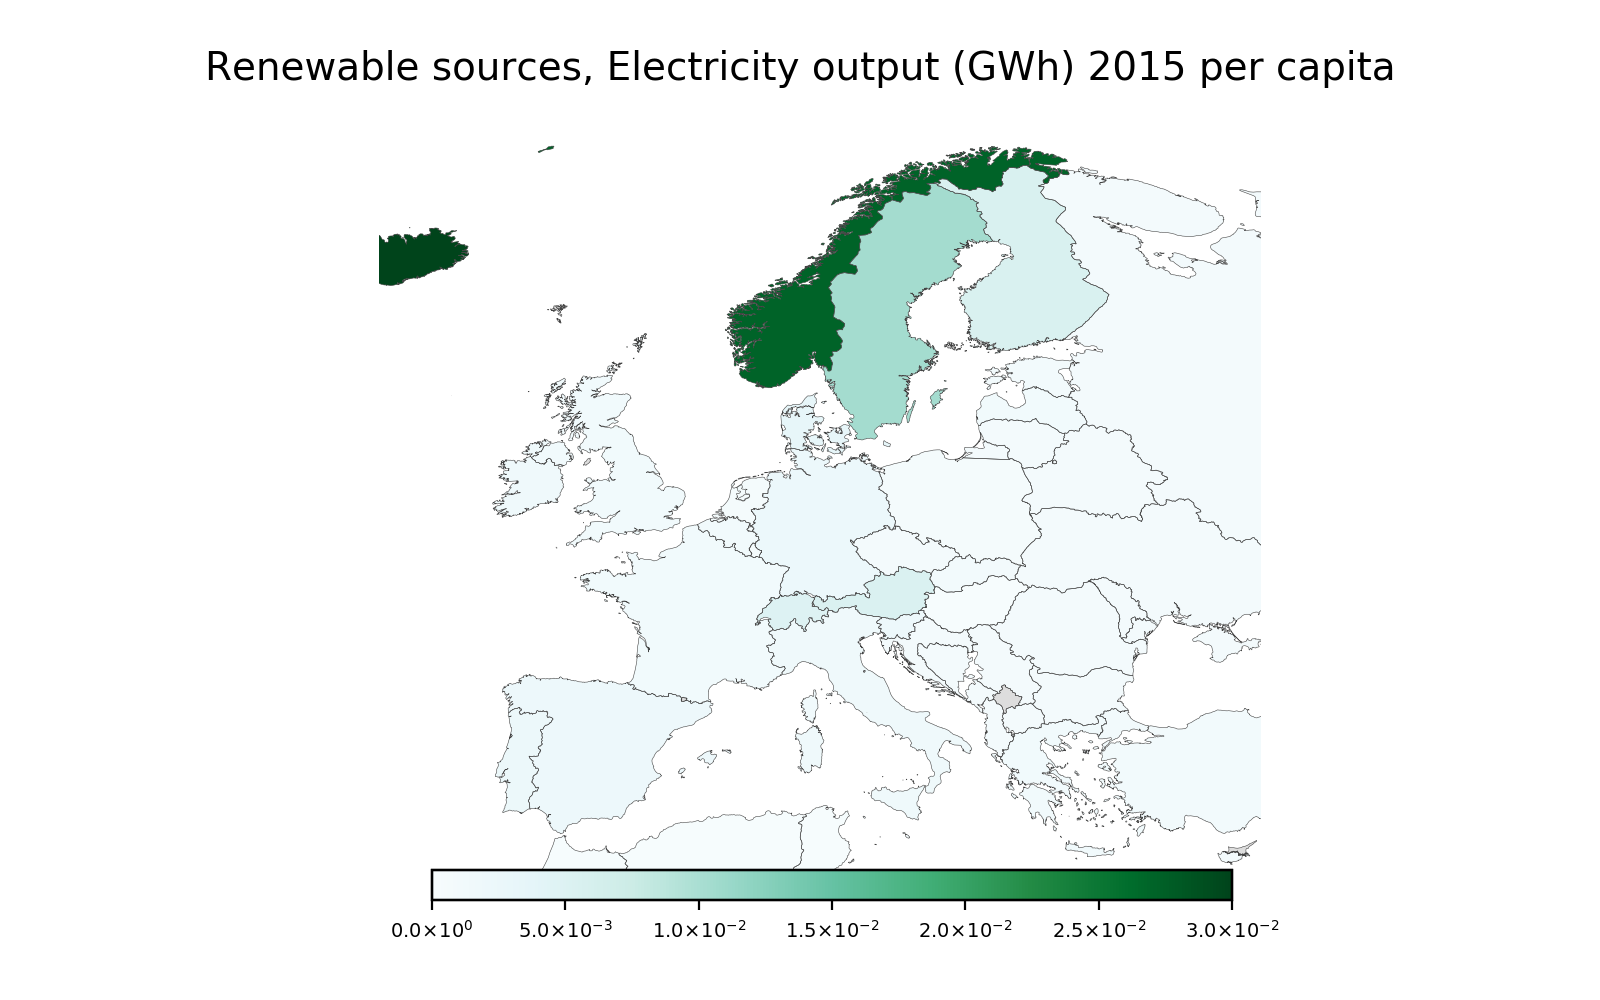

In [423]:
data_obj.plot_chloropleth(cmap='BuGn',min_max=[0,3e-2])

In [414]:
data_obj.data*1e2

,2015
Country,
Australia,0.144624
Austria,0.547227
Belgium,0.128311
Canada,1.17897
Chile,0.185062
Czech Republic,0.0893414
Denmark,0.333633
Estonia,0.114185
Finland,0.557073
